# Best Wordle Words

[Wordle](https://www.powerlanguage.co.uk/wordle/) is extremely popular these days,
and for good reason: it is so simple and elegant; a real joy.

*Wordle* reminds us that the best of games are simple in nature, with few rules,
and a great deal of freedom for players to develop their own strategies.
But, don't let *Wordle*'s apparent simplicity fool you... it is all too easy
to guess words ineffectively, and to lose!

In this arrticle I will try to come up with some good words for initial guesses to *Wordle*.

## 5-Letter Words

Let's assume that the only rule to *Wordle*'s choice of words is that it is a 5-letter word.
So, let's just get all 5-letter words.

In [1]:
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt

nltk.download("words")
all_words = nltk.corpus.words.words

five_letter_words = pd.DataFrame(
    [word.lower() for word in all_words() if len(word) == 5],
    columns=["word"],
)

[nltk_data] Downloading package words to /home/nicob/nltk_data...
[nltk_data]   Package words is already up-to-date!


How many 5-letter words do we have?

In [2]:
len(five_letter_words)

10422

Wow! That's a lot!

## Criteria for a Good Guess

There are many theories on what makes a good guess,
so please don't judge... but here is my naive simple criteria for a good guess:

* Contains as many common letters as possible
* Contains as many different letters as possible
* Contains as many letters in common places as possible

For now, let's keep it this simple. We can always make things more complicated later...

## Collecting the Data

This is not so tricky...
We look at each word, look at which letters we find at each position in each word,
and keep track of everything.
Later we can use this data to calculate everything we need.

In [3]:
def get_letters_data():
    data = []
    for word in five_letter_words["word"]:
        for position, letter in enumerate(word):
            data.append({"letter": letter, "position": position + 1})
    return pd.DataFrame(data)


letters = get_letters_data()

This data is a table whose rows contain two values: a letter; its position in a word.
It might not seem like much, but it's all we need. Here's a quick glance at what
this table looks like:

In [4]:
letters.head()

,letter,position
0,a,1
1,a,2
2,l,3
3,i,4
4,i,5


## Most Common Letters

Given our data, we can now count the occurences of each letter.
This reflects how commonly each letter is found in any word.
To calculate this we take a look at our letters data,
group them by letter, and tally up the count.

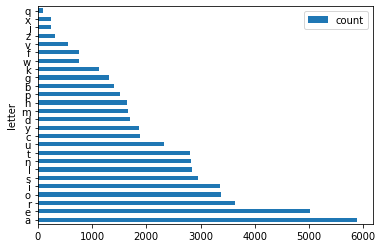

In [14]:
letters_count = letters.groupby("letter").count()
letters_count.columns = ["count"]
letters_count = letters_count.sort_values(by="count", ascending=False)
letters_count.plot.barh(y="count")
plt.show()

I don't know about you, but these results surprised me!
The top 10 letters are:

In [6]:
letters_count.head(10)

,count
letter,
a,5879
e,5019
r,3640
o,3372
i,3365
s,2954
l,2848
n,2827
t,2807


And the lowest 10 are:

In [7]:
letters_count.tail(10)

,count
letter,
b,1397
g,1319
k,1121
w,764
f,755
v,555
z,308
j,251
x,241


## Most Common Positions of Letters

This is a little trickier...
We group our data by letter and position, and count how many occurences
of each letter-position combination.

In [8]:
letters_position = pd.DataFrame(
    {"count": letters.groupby(["letter", "position"]).size()}
)

Here's what it looks like for the letter `a`

In [9]:
letters_position.loc["a"]

,count
position,
1,810
2,1837
3,1040
4,1162
5,1030


## What is the Best Guess?

Okay, now we can start to apply our criteria for a good guess to determine
which word is best! Here is our strategy:

* Given any 5-letter word,
    * we tally up how common each of its letters are
        * we only count each letter once, to favour words with different letters
    * we tally up how common the position of each letter is
        * here, we count each letter, include duplicates

Anyway, I'm bad at explaining things... here goes nothing!

In [10]:
def compute_score(word: str) -> int:
    score = 0
    unique_letters = list(set(word))
    for letter in unique_letters:
        score += letters_count.loc[letter]["count"]
    for i, letter in enumerate(word):
        position = i + 1
        score += letters_position.loc[letter, position]["count"]
    return score

So, here's what the score of `apple` and `great` would be:

In [11]:
compute_score("apple")

18588

In [12]:
compute_score("great")

22559

In [13]:
five_letter_words["score"] = [compute_score(word) for word in five_letter_words["word"]]

five_letter_words.sort_values("score", ascending=False).head(20)

,word,score
8734,tarie,26683
7365,saite,26123
6907,raise,26037
7635,serai,25961
8742,tarse,25856
8131,solea,25853
8130,solea,25853
7849,sinae,25812
7636,seral,25695
8457,strae,25541


## Conclusion

Don't let this fancy code and math fool you,
this is a naive approach. We are simply looking at
which letters are most common, and which positions of letters
are most common, and picking words that maximize this combination.
There are a ton of other details that this code simply isn't considering.

In the end, this article may help you come up with a decent first guess,
but the rest is up to you! Anyway, good luck on your next *Wordle*  game,
and don't forget to try out one of the top words!